In [1]:
import tensorflow as tf
import numpy as np
import time  
import os

In [2]:
path = 'Data/shakespeare.txt'
text = open(path, 'rb').read().decode(encoding = 'utf-8')

In [3]:
print("The number of characters in the file including the spaces and all the literals (such as ',\" \\n)")
print(f"Number : {len(text)} characters")

The number of characters in the file including the spaces and all the literals (such as '," \n)
Number : 1115394 characters


In [4]:
i = 250
print(f"\t\tThe first {i} characters")
print("_"*50)
print("\n"+text[:i])

		The first 250 characters
__________________________________________________

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
vocab = sorted(set(text))
print("The number of unique character in the dataset : ",len(vocab))

The number of unique character in the dataset :  65


In [6]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [7]:
text_as_int  = np.array([char2idx[c] for c in text])

In [8]:
print("The first line in text: ",text[:13])
print("The first line in int: ",text_as_int[:13])

The first line in text:  First Citizen
The first line in int:  [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [9]:
max_length = 100
seq_length = max_length
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [10]:
sequences = char_dataset.batch(seq_length + 1, drop_remainder = True)

In [11]:
for item in sequences.take(1):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [12]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    output_text = chunk[1:]
    return input_text, output_text

In [13]:
dataset = sequences.map(split_input_target)

In [14]:
batch_size = 64
buffer_size = 10000

In [15]:
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder = True)

In [16]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_unit = 1024

In [17]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
    return model

In [18]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_unit,
    batch_size=batch_size)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [20]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
model.compile(optimizer='adam', loss=loss)

In [23]:
history = model.fit(dataset, epochs = 1)

172/172 [==============================] - 270s 2s/step - loss: 2.0990


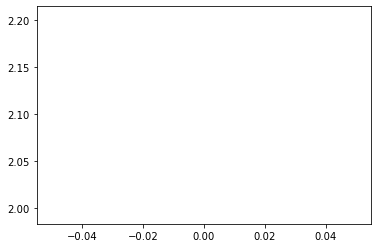

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [26]:
model.save('saved_model/model.h5') 

In [27]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
    num_generate = 1000

  # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
    text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
    temperature = 1.0

  # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [28]:
model = build_model(vocab_size, embedding_dim, rnn_unit, batch_size=1)
model.load_weights('saved_model/model.h5')
model.build(tf.TensorShape([1, None]))

In [29]:
print(generate_text(model, start_string=u"Hi"))

Hign:
Prithines the concould my whare yours afomaty beatory:
I pay deep form buce ser jettrecterse.

First Leme Am CaniSk!
How some shath bef that thece lake.

IUCHARWICK:
Yee, geaked hear's tike ant gracured it.


LORIO:
'ting sir aswam the kingh Fert thy ledd
Un to dif.

GROOLANUS:
You. Fire lebe profound lerv le gy
And and grome:
't thau him regntly swall of lear then frome,
This fral of shople, whend but sit munt de it reing on, thou foor that.

RESTIO: thouks ald the sotess or with dorder,
It enebow, I tmimp yen mo deated tene ry donguth.

Sidnte: you han!

BUCEOLILAS:
My plactenit ofsenchnied, the plastit
Unt:
Wo kienks that woold goid with be dowho stiated-dby wielly fello and beck'd my of thimf
But then it of beanedy ond
Marray you, lysseard
enos your dusthise outh. Whe redare it in with I have agriof, thty him penvell be romes mirest vord hith; and with all of fer vorkint,
And perant
Ay im
How I and endane,
That ta ut rees fleremand.
O, Whath bee glasess bloft an frane the exi